In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

## 1. Дослідження та підготовка даних

In [ ]:
#Файл тестових даних
df = pd.read_csv('/content/Data Analyst Test Task Data - Tasks 1-2.csv')
df.head(3)

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,Unnamed: 10,Unnamed: 11
0,ac104b42-b68c-415d-9555-02365fa983ee,2023-10-14 0:14:44,purchase,weekly.4.99.3d.trial,True,7,3,4.99,3842d2b8-8cd8-4d89-b31d-eda795d49997,NaN,NaN,NaN
1,ac104b42-b68c-415d-9555-02365fa983ee,2023-04-25 11:10:00,trial,weekly.4.99.3d.trial,True,7,3,4.99,8d5c3d06-7784-4dfc-8c1f-b0865947a1d3,NaN,NaN,NaN
2,ac104b42-b68c-415d-9555-02365fa983ee,2023-05-27 8:33:26,purchase,weekly.4.99.3d.trial,True,7,3,4.99,2cae6d6b-fa5f-403a-acfc-dd7b42619a42,NaN,NaN,NaN


In [ ]:
# Перетворення event_timestamp у формат дати
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
purchases = df[df['event_name'] == 'purchase'].copy()

In [ ]:
# Визначення когортної дати
first_purchase_date = purchases[purchases['event_name'] == 'purchase'].groupby('uuid')['event_timestamp'].min().reset_index()
first_purchase_date.columns = ['uuid', 'first_purchase_date']
purchases = pd.merge(purchases, first_purchase_date, on='uuid')

In [ ]:
# Визначення номера підписки (rebill)
purchases = purchases[['uuid','product_id', 'first_purchase_date', 'event_timestamp','transaction_id']].copy()
purchases.sort_values(by=['uuid', 'product_id', 'event_timestamp'], inplace=True)

purchases['renewal_number'] = purchases.groupby(['uuid', 'product_id']).cumcount() + 1

Для побудови моделі LTV важливо розуміти інтервали між списаннями.

In [ ]:
# Розрахунок різниці в датах (date_diff) між поточною та попередньою транзакцією
purchases['previous_timestamp'] = purchases.groupby(['uuid', 'product_id'])['event_timestamp'].shift(1)
purchases['date_diff'] = (purchases['event_timestamp'] - purchases['previous_timestamp']).dt.days
purchases.drop('previous_timestamp', axis=1, inplace=True)

# Перегляд результатів
purchases.head(3)

,uuid,product_id,first_purchase_date,event_timestamp,transaction_id,renewal_number,date_diff
2113,00026e14-e302-4772-b691-8b0e67ab0c32,weekly.2.49,2023-06-05 23:10:44,2023-06-05 23:10:44,b672df8a-fcb2-4737-8a5f-98a85b183609,1,NaN
2114,00026e14-e302-4772-b691-8b0e67ab0c32,weekly.2.49,2023-06-05 23:10:44,2023-06-12 23:10:57,33254b74-1437-4eb1-a71d-be3c0958bdf8,2,7.0
2115,00026e14-e302-4772-b691-8b0e67ab0c32,weekly.2.49,2023-06-05 23:10:44,2023-06-19 23:10:53,b0e50445-f8bb-4677-86c9-e34f49a274ab,3,6.0


Подивимось які інтервали між ребілами зустрічаються найчастіше в розрізі продуктів:

In [ ]:
date_diff_count = purchases.groupby(['product_id','date_diff'])['uuid'].count().reset_index()
date_diff_count.columns = ['product_id','date_diff', 'transaction_count']
date_diff_count.sort_values(by=['transaction_count'],ascending=False).head(10)

,product_id,date_diff,transaction_count
84,weekly.2.49,6.0,2443
85,weekly.2.49,7.0,2323
152,weekly.4.99.3d.trial,6.0,1981
153,weekly.4.99.3d.trial,7.0,1961
38,monthly.9.99.3d.trial,6.0,1082
39,monthly.9.99.3d.trial,7.0,1050
6,monthly.7.49,6.0,552
7,monthly.7.49,7.0,536
78,weekly.2.49,0.0,114
146,weekly.4.99.3d.trial,0.0,78


Припускаючи, що усі продукти мають 7ми денний rebill-період, тоді подивимось на % транзакцій що відхиляються від цього значення.

In [ ]:
date_diff_count['gr'] = np.where(date_diff_count['date_diff']==7,'+-7',
              np.where(date_diff_count['date_diff']== 6, '+-7','><7' ))
date_diff_count2 = date_diff_count.groupby(['gr'])['transaction_count'].sum().reset_index()
date_diff_count2.columns = ['gr', 'transaction_count']
date_diff_count2.sort_values(by=['transaction_count'],ascending=False).head(10)

,gr,transaction_count
0,+-7,11928
1,><7,1445


Бачимо що % відхилень не більший ніж 10%, тому вважатимемо що  модель на основі платіжного retention буде мати задовільну похибку.

In [ ]:
purchases.drop('date_diff', axis=1, inplace=True)

## 2. Побудова моделі

Модель будуватимемо на основі платіжного рененешену. Задача полягає в обчисленні фактичного та прогнозуванні 6-ти місячного gross LTV. Враховучи, що за 6 місяців юзер може оплатити максимум 27 підписок (26 тижнів) з урахуванням визначного вище інтервалу ребілу (26 * 7 / 30 ~= 6.06), будемо розглядати Retention як CR з 1 до 27 підписки.

In [ ]:
purchases_t = purchases.copy()

In [ ]:
# Визначення тижневої когорти
purchases_t['first_purchase_date'] = pd.to_datetime(purchases_t['first_purchase_date'])
purchases_t['week_cohort'] = purchases_t['first_purchase_date'].dt.to_period('W').dt.start_time

In [ ]:
# Побудова таблиці retention у вигляді півоту
unique_users_per_cohort_product = purchases_t.groupby(
    ['week_cohort', 'product_id', 'renewal_number'])['uuid'].nunique().reset_index()
pivot_data = unique_users_per_cohort_product.pivot_table(index=['week_cohort', 'product_id'],
                                                         columns='renewal_number',
                                                         values='uuid',
                                                         fill_value=0).reset_index()

pivot_data.columns = ['week_cohort', 'product_id'] + [f'{i}' for i in range(1, len(pivot_data.columns)-1)]

In [ ]:
pivot_data.head(5)

,week_cohort,product_id,1,2,3,4,5,6,7,8,...,27,28,29,30,31,32,33,34,35,36
0,2023-02-27,monthly.7.49,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2023-02-27,monthly.9.99.3d.trial,9,6,5,5,5,5,5,3,...,2,2,2,1,1,1,1,0,0,0
2,2023-02-27,weekly.2.49,21,12,11,11,9,8,7,7,...,2,2,1,1,1,1,1,0,0,0
3,2023-02-27,weekly.4.99.3d.trial,23,15,13,12,9,9,9,8,...,4,2,2,2,2,1,1,0,0,0
4,2023-03-06,monthly.7.49,23,13,11,9,9,9,7,7,...,5,5,5,5,5,3,2,0,0,0


In [ ]:
#Лишаємо лише релевантні для 6ти місячного LTV данні
sub_N = 27

pivot_data_t = pivot_data.iloc[:, 0:(sub_N+2)].copy()

Буватимемо прогноз в залежності від product_id, адже продукти мають різний прайсинг та відповідно ріні поведінкові патерни.

In [ ]:
#Список унікальних продуктів
unique_product_ids = pivot_data_t['product_id'].unique()

#Розділення півот-таблиць по продуктам
dfs_split_by_product_id = {product_id: pivot_data_t[pivot_data_t['product_id'] == product_id].reset_index().copy()
                            for product_id in unique_product_ids}
list(dfs_split_by_product_id.keys()), len(dfs_split_by_product_id)

(['monthly.7.49',
  'monthly.9.99.3d.trial',
  'weekly.2.49',
  'weekly.4.99.3d.trial'],
 4)

Отримали вхідні дані для прогнозу:

In [ ]:
for product_id in unique_product_ids:
  dfs_split_by_product_id[product_id].drop('product_id', axis=1, inplace=True)
  dfs_split_by_product_id[product_id].drop('index', axis=1, inplace=True)

### Опис моделі
Враховуючи, що обʼєм тижневих когорт невеликий, будемо використовувати метод ланцюгових коефіцінтів. Цей метод дозволяє за максимально «свіжими» даними обрахувати ретешн. Суть способу полягає в тому, щоб визначати ретешн на кожен період окремо за останніми відомими когортами. Тобто для кожного ребілу буде свій пул когорт, за яким вираховуватиметься рейт. Спершу визначимо цей пул:

In [ ]:
#параметри прогнозу
window = 5 #розмір вікна для обчислення ланцюгового коефіцієнта

Функція forecast():

*   приймає за аргумент дані по ренетншену
*   спершу запускаємо цикл, що проходиться по усім когортам
*   далі визначаємо для поточної когорти підписку з якої потрібно допрогнозовувати криву ретеншену
*   далі запускаємо цикл для поточної когорти по цим підпискам і для кожної визначаємо ланцюговий коефіцієнт переходу
*   множимо ланцюговий коефіцієнт на кількість юзерів поепердньої підписки
*   записуємо оновлення значення в датафрейм


Функція chain_coefficient():

*   приймає як аргумент дані по ренетншену, індекс когорти від якої починаємо прогноз та номер підписки яку прогнозуємо
*   спершу визначаємо пул когорт для обчичлення ланцюгового коефіцієнту -- кількість юзерів потчоної підписки на кількість юзерів попередньої підписки (суму берем по когортам, що обмежені розміром пулу -- weighted average)

In [ ]:
#функція різниці дат
def date_diff_in_weeks(date1, date2):
    return abs((date2 - date1).days) // 7

#функція визначення ланцюгового коефіцієнту
def chain_coefficient(df, current_cohort_index, churn_number):

    # розрахрвуємо вікно попередніх періодів, звідки братимемо значення chain CR
    start_index = max(0, current_cohort_index - window)
    previous_cohorts = df.iloc[start_index:current_cohort_index]

    # розрахуєво середньозважений chain CR
    if len(previous_cohorts) > 0 and churn_number > 1:
        previous_churn_values = previous_cohorts[f'{churn_number}'].to_numpy()
        previous_before_churn_values = previous_cohorts[f'{churn_number-1}'].to_numpy()

        total_previous_churn = np.sum(previous_churn_values)
        total_previous_before_churn = np.sum(previous_before_churn_values)

        chain_coefficient = total_previous_churn / total_previous_before_churn if total_previous_before_churn != 0 else 0

        return chain_coefficient
    else:
        return 0

def forecast(df):
    df['week_cohort'] = pd.to_datetime(df['week_cohort'])
    max_date = df['week_cohort'].max()

    forecast_df = df.copy()
    #Цикл перевірки кожної когорти, для допоргнозовування
    for index, row in forecast_df.iterrows():
        cohort_date = row['week_cohort']
        weeks_diff = date_diff_in_weeks(cohort_date, max_date)

        # Обираємо підписку з якої починаємо прогноз
        start_churn_number = weeks_diff - 1
        # Ідентифікатор зсуву (щоб для кожної наступної підписки брати періоди із сувом на 1)
        i = 0
        # Цикл прогнозування підписок від N до 27
        for churn_number in range(max(2, start_churn_number),sub_N+1):
            conversion_coefficient = chain_coefficient(forecast_df, index - i, churn_number)
            if churn_number == start_churn_number:
                forecast_value = row[f'{churn_number-1}'] * conversion_coefficient if churn_number > 1 else row[f'{churn_number}']
            else:
                forecast_value = forecast_df.at[index, f'{churn_number-1}'] * conversion_coefficient
            i+=1
            forecast_df.at[index, f'{churn_number}'] = forecast_value

    return forecast_df



Результати прогнозу ретеншену для кожного продукту окремо:

In [ ]:
forecasted_dfs = {product_id: forecast(dfs_split_by_product_id[product_id].copy())
                            for product_id in unique_product_ids}

In [ ]:
forecasted_dfs['weekly.4.99.3d.trial'][forecasted_dfs['weekly.4.99.3d.trial']['week_cohort']=='2023-05-08']

,week_cohort,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
10,2023-05-08,64,44.0,36.0,29.0,25.0,19.0,15.0,14.0,11.0,...,6.0,5.0,4.545455,4.181818,4.0,3.652174,3.286957,3.173613,3.056072,2.923199


Тепер обчислимо LTV:

In [ ]:
#Вартість підписки для кожного продукту
pricing = {'monthly.7.49': 7.49,
  'monthly.9.99.3d.trial': 9.99,
  'weekly.2.49': 2.49,
  'weekly.4.99.3d.trial': 4.99}

In [ ]:
for product_id in unique_product_ids:
  forecasted_dfs[product_id]['gross_LTV'] = forecasted_dfs[product_id].iloc[:, 1:28].sum(axis=1) * pricing[product_id]
  forecasted_dfs[product_id]['gross_LTV_per_user'] = forecasted_dfs[product_id]['gross_LTV'] / forecasted_dfs[product_id]['1']

In [ ]:
forecasted_LTV_by_product_id = {
    product_id: forecasted_dfs[product_id]
    [['week_cohort','1', 'gross_LTV', 'gross_LTV_per_user']].copy()
                            for product_id in unique_product_ids}

Результати прогнозу окремо для кожного продукту.

In [ ]:
forecasted_LTV_by_product_id['weekly.2.49'].head(4)

,week_cohort,1,gross_LTV,gross_LTV_per_user
0,2023-02-27,21,403.38,19.208571
1,2023-03-06,94,1668.30,17.747872
2,2023-03-13,67,1190.22,17.764478
3,2023-03-20,87,1434.24,16.485517


In [ ]:
combined_df = pd.concat([forecasted_dfs[product_id]
    [['week_cohort','1', 'gross_LTV']].copy()
                            for product_id in unique_product_ids
]).groupby('week_cohort').sum().reset_index()
combined_df['gross_LTV_per_user'] = combined_df['gross_LTV'] / combined_df['1']

Агреговані результати прогнозу LTV для тижневих когорт.

In [ ]:
combined_df

,week_cohort,1,gross_LTV,gross_LTV_per_user
0,2023-02-27,55,2480.230000,45.095091
1,2023-03-06,240,9428.880000,39.287000
2,2023-03-13,169,6487.620000,38.388284
3,2023-03-20,201,6523.869130,32.457060
4,2023-03-27,115,3660.915362,31.834047
5,2023-04-03,106,4331.887093,40.866859
6,2023-04-10,102,3170.801259,31.086287
7,2023-04-17,130,5379.944507,41.384189
8,2023-04-24,161,6284.866624,39.036439
9,2023-05-01,182,5390.943638,29.620569


## **Summary**


Оцінити якість запропонованої моделі важкувато, адже стабільні обʼєми когортних даних спостерігаються до тижня 2023-06-12, відповідно дослідити поведінку моделі на свіжих юзерах неможливо -- надто велика волатильність на обʼємі когорти до 20 юзерів.
Якщо порівнювати результати прогнозу з фактичними даними (це сума revenue за 6 місяців з моменту першого purchase). Бачимо похибку в межах 5%, що обумволеною інакшою механікоб обчислення -- когортна сума ревенʼю за 6 місяці та когортний ревенʼю за 27 підписок.


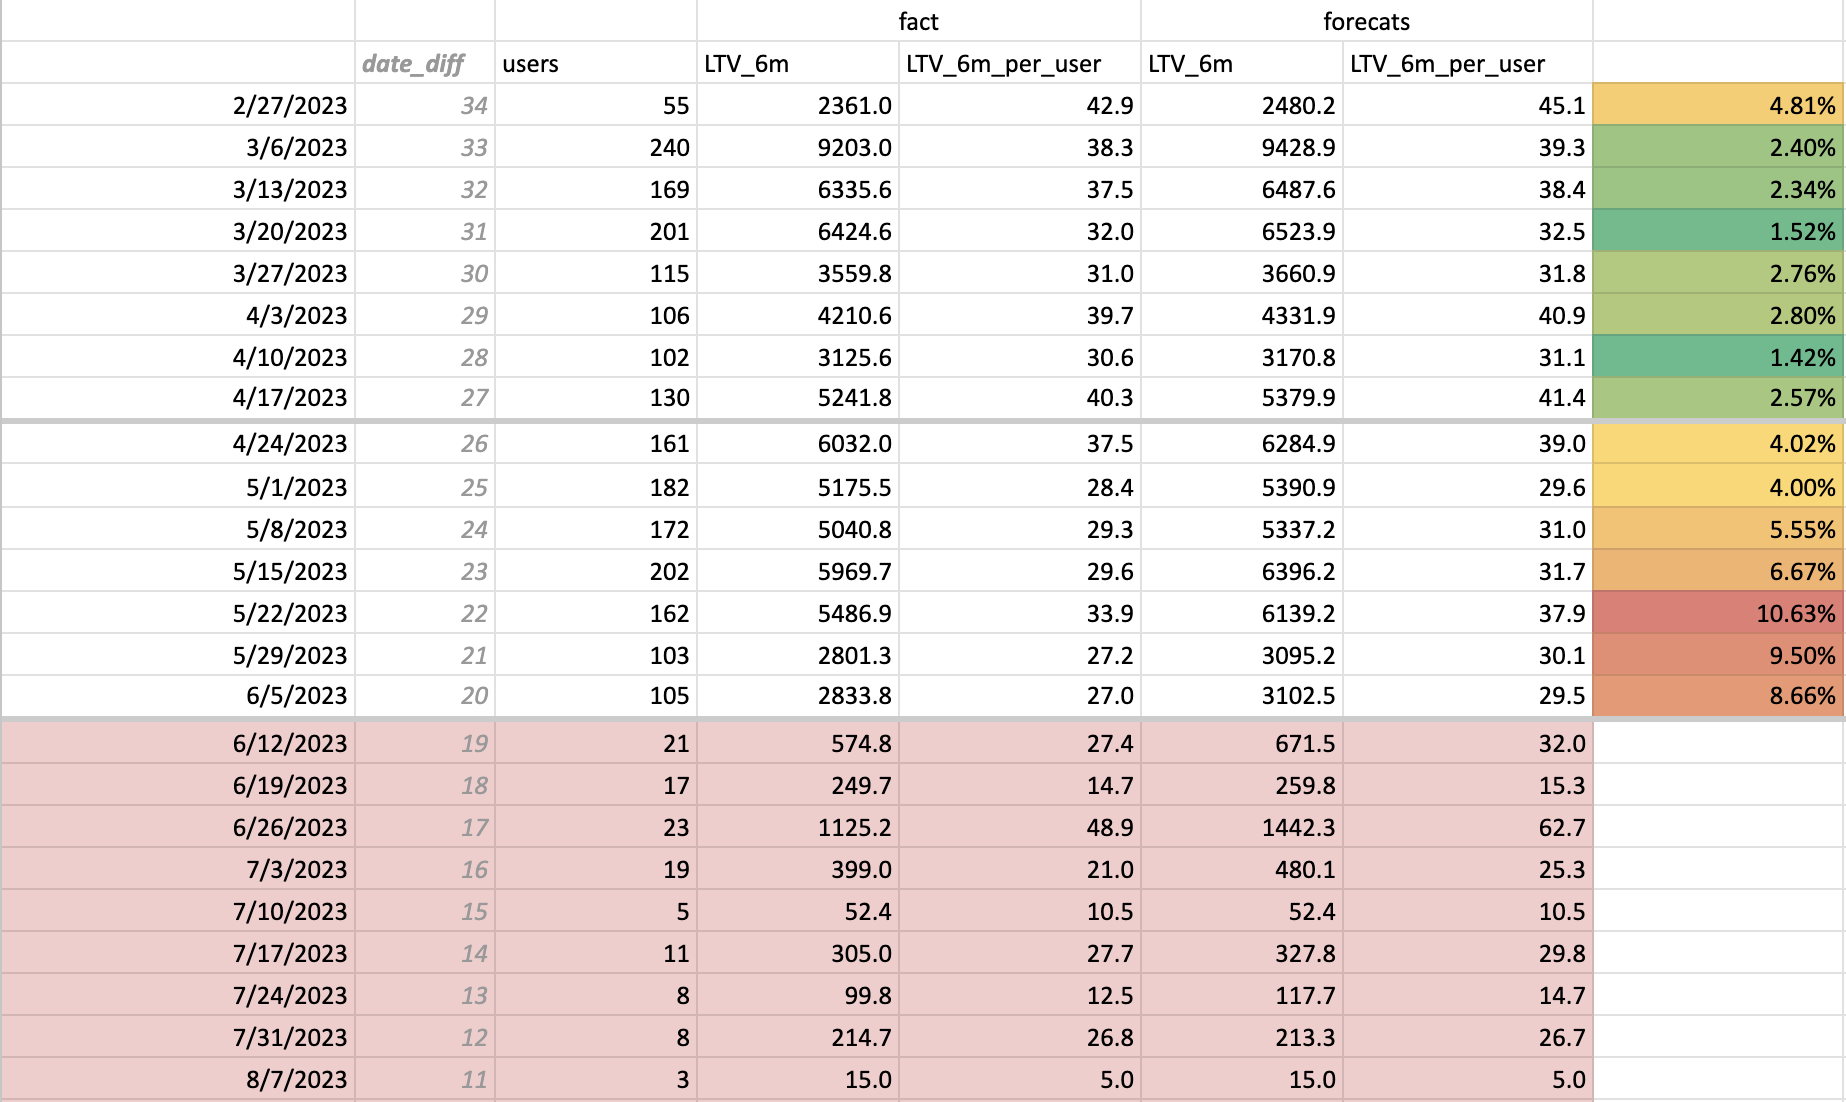

### **Яким чином можна поліпшити прогноз?**


1.   Збільшити обсяг даних. Це допоможе на етапі валідації моделі відрегулювати параметри прогнозу (наприклад розмір вікна для обчислення ланцюгового коефіцієнту). Та я в цілому це допоможе зрозуміти якість моделі.
2.   Якщо обʼєм когорти збільшиться, можна розширити сегментацію (не тільки по продуктам). Розглядати ретеншен в розрізі країн, макренгових сорсів чи палатіжних методів.
3.   Комбінація моделей для прогнозування. Для прогнозування ретеншену для свіжих когорт ланцюгові коефіцієнти добре підходять, адже вони допомогають відловити свіжі зміни у поведінці користувачів. Але для хвостів краще підходять усереднені моделі -- лінійна або експоненційна регресії.
4.   Розуміння походження даних. Розуміння походження даних та їх особливостей допомогає під час генерації гіпотез щодо поліпшення прогнозу.




